In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Dataset

Dataset Link - https://www.kaggle.com/datasets/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018

In [3]:
example = pd.read_parquet('data/2gb_dataset/unprocessed/2012.parquet', engine='pyarrow')

#drop the unnamed column
example = example.drop(columns=['Unnamed: 27'])
example

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2012-01-01,MQ,4041,BMI,ORD,1715.0,1702.0,-13.0,9.0,1711.0,...,0.0,55.0,55.0,37.0,116.0,NaN,NaN,NaN,NaN,NaN
1,2012-01-01,MQ,4041,ORD,BMI,1545.0,1540.0,-5.0,11.0,1551.0,...,0.0,50.0,39.0,23.0,116.0,NaN,NaN,NaN,NaN,NaN
2,2012-01-01,MQ,4042,SGF,ORD,715.0,705.0,-10.0,12.0,717.0,...,0.0,115.0,105.0,75.0,438.0,NaN,NaN,NaN,NaN,NaN
3,2012-01-01,MQ,4045,ORD,DBQ,1535.0,1529.0,-6.0,13.0,1542.0,...,0.0,55.0,46.0,31.0,147.0,NaN,NaN,NaN,NaN,NaN
4,2012-01-01,MQ,4047,ORD,RIC,1600.0,1615.0,15.0,12.0,1627.0,...,0.0,115.0,109.0,86.0,642.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6096757,2012-12-31,YV,1036,HNL,KOA,1600.0,1610.0,10.0,14.0,1624.0,...,0.0,40.0,50.0,32.0,163.0,0.0,0.0,10.0,0.0,10.0
6096758,2012-12-31,YV,1054,HNL,KOA,1252.0,1250.0,-2.0,15.0,1305.0,...,0.0,40.0,52.0,32.0,163.0,NaN,NaN,NaN,NaN,NaN
6096759,2012-12-31,YV,1004,HNL,LIH,1300.0,1321.0,21.0,17.0,1338.0,...,0.0,37.0,45.0,21.0,102.0,0.0,0.0,8.0,0.0,21.0
6096760,2012-12-31,YV,1005,HNL,LIH,1500.0,1500.0,0.0,12.0,1512.0,...,0.0,37.0,41.0,25.0,102.0,NaN,NaN,NaN,NaN,NaN


## Columns

In [4]:
example.columns 

Index(['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'],
      dtype='object')

## Data related to time of flight

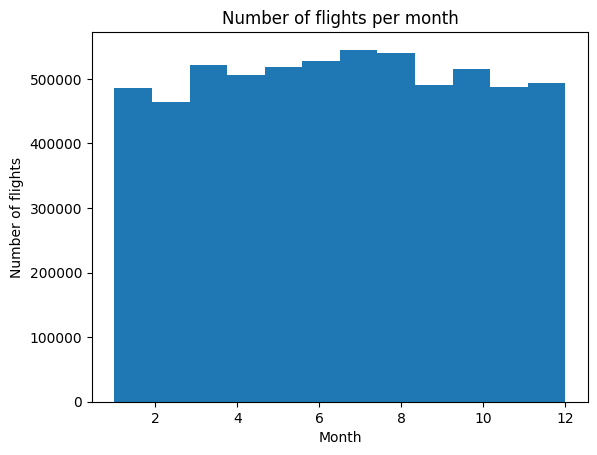

In [5]:
## converting date column to datetime obj
example['FL_DATE'] = pd.to_datetime(example['FL_DATE'], format='%Y-%m-%d')

## adding a column for month
example['FL_MONTH'] = example['FL_DATE'].dt.month

## adding a column for day of week
example['FL_DAY_OF_WEEK'] = example['FL_DATE'].dt.dayofweek

## adding a column for day of month
example['FL_DAY_OF_MONTH'] = example['FL_DATE'].dt.day

## plotting the number of flights per month
plt.title('Number of flights per month')
plt.xlabel('Month')
plt.ylabel('Number of flights')
plt.hist(example['FL_MONTH'], bins=12)
plt.show()
